In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
# pd.set_option('display.max_columns', 50)

In [3]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/uchicago trading/Training Data_Case 3.csv", index_col=0)

In [4]:
df

,A,B,C,D,E,F,G,H,I,J
1,119.96,198.25,76.54,32.08,53.20,19.47,40.63,43.47,19.76,113.91
2,120.32,201.42,76.73,31.86,53.88,19.23,40.47,45.16,19.88,112.98
3,119.60,200.23,77.60,31.56,55.11,18.93,39.84,46.03,20.29,114.24
4,121.76,199.61,79.48,31.62,55.80,19.15,40.13,46.89,20.01,114.27
5,120.10,199.64,81.49,31.89,55.02,19.16,39.94,47.59,20.12,113.87
...,...,...,...,...,...,...,...,...,...,...
2516,317.31,1385.04,199.14,273.02,52.11,89.45,151.54,390.13,88.25,35.99
2517,317.20,1358.01,202.59,277.45,52.73,90.93,152.39,394.03,87.56,35.89
2518,312.31,1315.00,198.29,281.23,52.71,92.28,153.92,375.70,89.54,36.13
2519,312.45,1319.59,200.78,282.77,52.26,93.49,155.26,368.33,91.36,35.15


<Axes: >

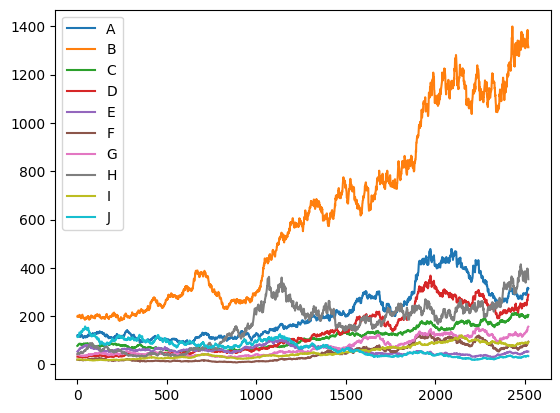

In [5]:
df.plot()

## Create projections

In [6]:
# Get daily % returns given prices
def make_df(df):
    df['shift']=df[df.columns[0]].shift(1)
    df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
    df=df.drop(columns='shift')
    return df

In [7]:
# Generate list of projections
def gen_data(df, first_day, runs, days):
    
    # Create list of arrays with projected daily returns
    data=[]
    first_prices=[]
    for x in range(len(df.columns)):
        temp=make_df(df.iloc[:,x:x+1])
        first_prices.append(temp[temp.columns[0]].iloc[first_day-1])
        data.append(np.random.laplace(loc=temp['PctChg'].mean(), scale=temp['PctChg'].std(), size=(runs, days)))
    
    # Get projected prices by applying % changes
    proj_dfs=[]
    for asset_num in range(len(data)):
        
        asset_data=[]
        for n in range(len(data[asset_num])):
            prices=[first_prices[asset_num]]
            for x in range(len(data[asset_num][n])):
                prices.append(prices[x]*(100+data[asset_num][n][x])/100)
            asset_data.append(prices)
        
        proj_arr=np.array(asset_data)
        proj_df=pd.DataFrame()
        for x in range(proj_arr.shape[0]):
            proj_df[str(x)]=proj_arr[x]
        proj_dfs.append(proj_df)
        
    # Transform dataframes
    dfs=[]
    for run_num in range(proj_dfs[0].shape[1]):
        temp=pd.DataFrame()
        for asset_num in range(len(proj_dfs)):
            prev_df=proj_dfs[asset_num]
            temp[str(asset_num)]=prev_df[prev_df.columns[run_num]]
        dfs.append(temp)
        
    return dfs

## Genetic algorithm

In [8]:
# Define global variable for square root of num trading days in a year
year_num=np.sqrt(252)

In [9]:
def gen_weights(df):
    weights=np.random.randint(0, 100000, len(df.columns))
    weights=weights/sum(weights)
    return weights

In [10]:
def gen_population(num_chrom, df):
    population=[]
    for x in range(num_chrom):
        population.append(gen_weights(df))
    return np.array(population)

In [11]:
def evaluate_chrom(chromosome, dfs):    
    sharpes=[]
    for x in range(len(dfs)):
        temp=dfs[x].multiply(chromosome, axis=1)
        test=temp[list(temp.columns)].sum(axis=1).pct_change()
        sharpe=(test.mean()/test.std())*year_num
        sharpes.append(sharpe)
    return np.mean(sharpes)

In [12]:
def evaluate_population(pop, proj_dfs):
    sharpes=[]
    for chrom in pop:
        sharpes.append(evaluate_chrom(chrom, proj_dfs))
    return np.array(sharpes)

In [13]:
# Choose chromosome for next generation given the cumulataive normalized sharpes
def choose_chrom(population, cum_norm_sharpes):
    for n in range(len(cum_norm_sharpes)):
        if cum_norm_sharpes[n]>np.random.rand(1)[0]:
            return population[n]

In [14]:
def crossover(chrom1, chrom2):
    if np.random.rand(1)[0]>.5:
        return np.concatenate((chrom1[:int(len(chrom1)/2)], chrom2[int(len(chrom1)/2):]), axis=None)
    else:
        return np.concatenate((chrom2[:int(len(chrom1)/2)], chrom1[int(len(chrom1)/2):]), axis=None)

In [15]:
def mutate(chrom, rate):
    new=[]
    for weight in chrom:
        if np.random.rand(1)[0]<rate:
            new_weight=weight*(1+np.random.normal(0, .4, 1)[0])
            if(new_weight<0):
                new.append(0)
            else:
                new.append(new_weight)
        else:
            new.append(weight)
    return np.array(new)

In [16]:
def rebalance(chrom):
    return chrom/sum(chrom)

In [17]:
# Create next generation of chromosomes (weights)
def next_gen(sharpes, population, mutation_rate):
    
    new_gen=[]
    
    # Select best fourth
    num_chosen_direct=round(len(population)/4)
    temp={}
    for x in range(len(sharpes)):
        temp[x]=sharpes[x]
    temp={k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
    keys=list(temp.keys())[-1*num_chosen_direct:]
    for x in keys:
        new_gen.append(population[x])
    
    # Select rest through crossover: create cumulative norm fitness list
    norm_sharpes=sharpes/sum(sharpes)
    cum_norm_sharpes=[norm_sharpes[0]]
    for n in range(1, len(norm_sharpes)):
        cum_norm_sharpes.append(cum_norm_sharpes[n-1]+norm_sharpes[n])
    for x in range(len(population)-num_chosen_direct):
        new_gen.append(crossover(choose_chrom(population, cum_norm_sharpes), choose_chrom(population, cum_norm_sharpes)))
        
    # Mutation and rebalance
    final=[]
    for x in new_gen:
        final.append(rebalance(mutate(x, mutation_rate)))
        
    return np.array(final)

In [18]:
def genetic_algo(prev_gen_sharpes, prev_gen, pop_size, mutation_rate, df, proj_dfs):
    
    # Add to high fitness weights dict
    max_sharpe=max(prev_gen_sharpes)
    best_weights=prev_gen[list(prev_gen_sharpes).index(max_sharpe)]
    high_fitness_weights[max_sharpe]=best_weights
    
    # Check convergence
    convergence=False
    if (len(high_fitness_weights)==30):
        convergence=True
    elif (len(high_fitness_weights)>1):
        if max_sharpe<list(high_fitness_weights.keys())[-2]*1.02:
            convergence_count.append(1)
        else:
            convergence_count.append(0)

        if (sum(convergence_count[-20:])==20):
            convergence=True
        else:
            convergence=False
    else:
        convergence_count.append(0)
    
    # Recursive GA
    if (convergence==False):
        print("Generation Number "+str(len(convergence_count)+1))
        print("---Processing")
        print("---Sharpe: "+str(max_sharpe))
        new_gen=next_gen(prev_gen_sharpes, prev_gen, mutation_rate)
        new_gen_sharpes=evaluate_population(new_gen, proj_dfs)
        print("---Done")
        genetic_algo(new_gen_sharpes, new_gen, pop_size, mutation_rate, df, proj_dfs)
    else:
        print("Convergence achieved")

## Test algorithm

In [19]:
# Create projections
proj_dfs=gen_data(df, first_day = 2520-30, runs = 50, days = 30)

<ipython-input-6-4989a155b21f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
<ipython-input-6-4989a155b21f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
<ipython-input-6-4989a155b21f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

<Axes: >

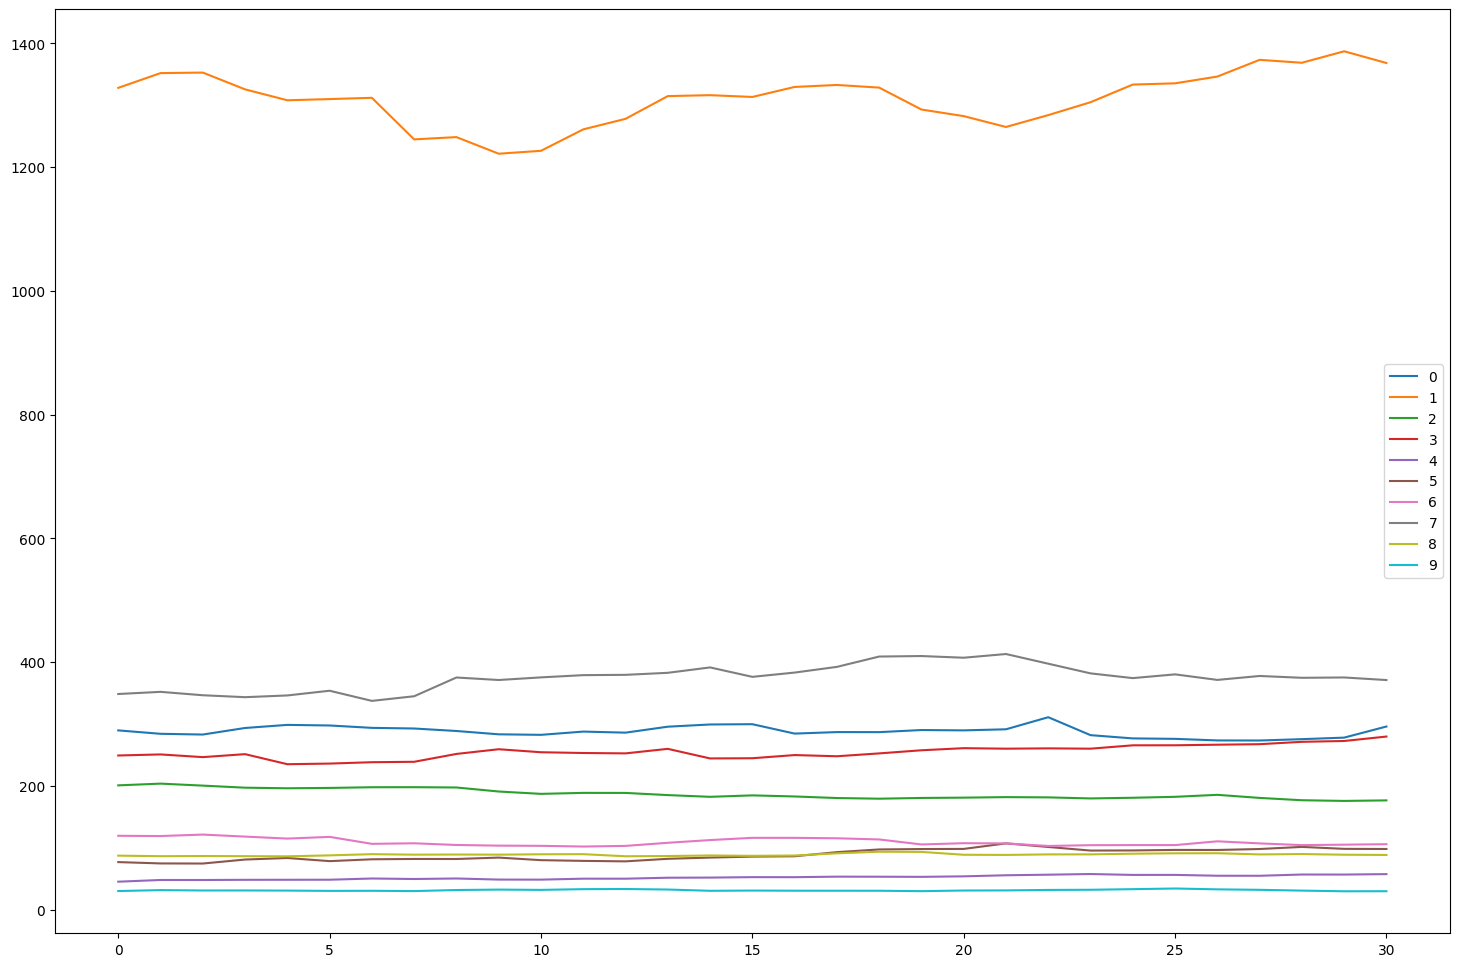

In [20]:
# Plot one set of projections
proj_dfs[0].plot(figsize=(18, 12))

In [21]:
# Define GA inputs
pop_size=25; mutation_rate=.5;

In [22]:
# Create initial population and evaluate
gen1=gen_population(pop_size, df);

In [23]:
# Run GA
sharpes=evaluate_population(gen1, proj_dfs)
high_fitness_weights={}
convergence_count=[]
genetic_algo(sharpes, gen1, pop_size, mutation_rate, df, proj_dfs)

Generation Number 2
---Processing
---Sharpe: 2.0592922089376007
---Done
Generation Number 3
---Processing
---Sharpe: 2.1291613842470145
---Done
Generation Number 4
---Processing
---Sharpe: 2.1234000295840385
---Done
Generation Number 5
---Processing
---Sharpe: 2.1114021497058593
---Done
Generation Number 6
---Processing
---Sharpe: 2.079268422617338
---Done
Generation Number 7
---Processing
---Sharpe: 2.099081998553656
---Done
Generation Number 8
---Processing
---Sharpe: 2.132198976467761
---Done
Generation Number 9
---Processing
---Sharpe: 2.0937970573647267
---Done
Generation Number 10
---Processing
---Sharpe: 2.122375232570112
---Done
Generation Number 11
---Processing
---Sharpe: 2.086409774800694
---Done
Generation Number 12
---Processing
---Sharpe: 2.134659278876045
---Done
Generation Number 13
---Processing
---Sharpe: 2.1124983826845547
---Done
Generation Number 14
---Processing
---Sharpe: 2.1058320606266183
---Done
Generation Number 15
---Processing
---Sharpe: 2.1476189251446898


In [24]:
max_sharpe=max(list(high_fitness_weights.items()))[0]
best_weights=max(list(high_fitness_weights.items()))[1]
print("Max Sharpe: "+str(max_sharpe))
print("Associated Weights: "+str(best_weights))

Max Sharpe: 2.1863491243838227
Associated Weights: [0.05849331 0.02201835 0.13996107 0.09897306 0.0049237  0.1312392
 0.15536583 0.05551688 0.33201173 0.00149687]
